# Create food product nutrient matrix

This notebook transforms the nutrients product data into a matrix for clustering

At the time of writing this code, the data is pulled from FoodData Central for Oct 2022, which is an upgrade to the 2018 Branded Foods product database: https://fdc.nal.usda.gov/download-datasets.html

This specific matrix construction is on the food_nutrient table.

__Note:__ At the time of this writing, all nutrient amounts were standardized per 100g and 100ml of food.



Field descriptions (https://fdc.nal.usda.gov/portal-data/external/dataDictionary)
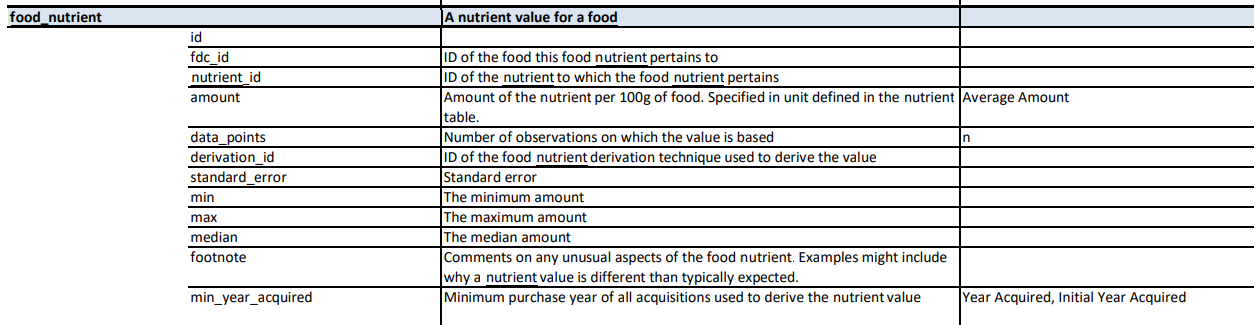



Update on “A Partnership for Public Health: USDA Global Branded Food Products Database” (https://www.sciencedirect.com/science/article/pii/S0889157521004506)
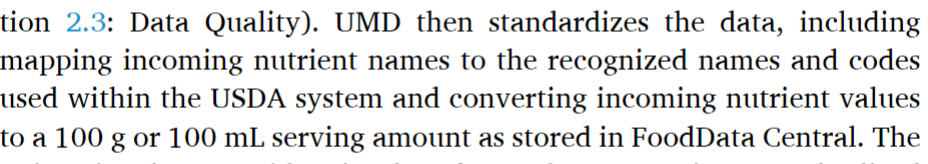

## Connect to the postgresql server and pull data

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sal

from sqlalchemy import text

In [2]:
nutrient_matrix_csv_p = r"../data/nutrients_matrix.csv.gz"

#### Connect to the database

In [7]:
#pip install psycopg2-binary

In [8]:
nourish_user = "gmichael"

nourish_pswd = "567khcwx3s"

engine = sal.create_engine('postgresql+psycopg2://' + nourish_user + ':' + nourish_pswd + '@awesome-hw.sdsc.edu/nourish')
conn = engine.connect()

#### Pull the list of nutrients by product
Use array_agg to get a list of nutrients and values. Delimit by '|'.

In [9]:
query_nutrients = text('''SELECT "fdc_id", array_agg("nutrient_id"||'|'||"amount" order by "nutrient_id")
from "usda_2022_branded_food_nutrients"
group by "fdc_id"''')

result = conn.execute(query_nutrients)

nutrient_data = [i for i in result]

nutrient_data[0:2]

[(344604, ['1003|0.81', '1004|0.41', '1005|4.07', '1008|24', '1079|0.8', '1082|0', '1084|0', '1087|13', '1089|0', '1092|179', '1093|203', '1110|0', '1253|0', '1257|0', '1258|0', '1292|0', '1293|0', '2000|2.44']),
 (344605, ['1003|0.81', '1004|0.41', '1005|4.07', '1008|24', '1079|0.8', '1082|0', '1084|0', '1087|16', '1089|0', '1092|179', '1093|203', '1110|0', '1253|0', '1257|0', '1258|0', '1292|0', '1293|0', '2000|2.44'])]

#### Pull the fdc_idcs and their ingredients

In [10]:
query_ingredients = text('''SELECT "fdc_id", "ingredients"
from "usda_2022_branded_food_product"''')

result = conn.execute(query_ingredients)

ingredient_data = [i for i in result]

ingredient_data[0:2]

[(2317926, 'Whole Grain Wheat Flour, Enriched Wheat Flour, (Wheat Flour, Malted Barley Flour, Niacin, Reduced Iron, Thiamine Mononitrate, Riboflavin, Folic Acid) ... (254 characters truncated) ... Oil), Honey, Wheat Starch, Calcium Stearate (Caking Agent), Monoglycerides, Propionic Acid And Phosphoric Acid (As Preservatives), Salt, Soybean Oil.'),
 (2317927, 'Ingredients: boned whole hog, water, salt, spices, and monosodium glutamate')]

## Create a food nutrient matrix

In [9]:
nutrient_df = pd.DataFrame(nutrient_data)
print(nutrient_df.shape)
nutrient_df.head(3)

(1590701, 2)


,fdc_id,array_agg
0,344604,"[1003|0.81, 1004|0.41, 1005|4.07, 1008|24, 107..."
1,344605,"[1003|0.81, 1004|0.41, 1005|4.07, 1008|24, 107..."
2,344606,"[1003|23.21, 1004|2.68, 1005|0, 1079|0, 1087|0..."


Create a function to convert the list to a dictionary.

In [10]:
def convert_to_dict(lst):
    output = {}
    for key_value in lst:
        key, value = key_value.split('|', 1)
        #handle duplicates by checking if key value already exists and taking average
        #not common with this data, but there are a few instances
        if key in output:
            output[key] = (output[key] + float(value))/2
        else:
            output[key] = float(value)
    return output

Update the array_agg column in the nutrients dataframe

In [11]:
nutrient_df['array_agg'] = nutrient_df['array_agg'].apply(lambda x: convert_to_dict(x))

In [12]:
nutrient_df.head(3)

,fdc_id,array_agg
0,344604,"{'1003': 0.81, '1004': 0.41, '1005': 4.07, '10..."
1,344605,"{'1003': 0.81, '1004': 0.41, '1005': 4.07, '10..."
2,344606,"{'1003': 23.21, '1004': 2.68, '1005': 0.0, '10..."


Use pd.json_normalize to pivot the dataframe on the nutrient column. Inspiration:

https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

In [13]:
nutrients_pivoted = pd.json_normalize(nutrient_df['array_agg'])
nutrients_pivoted.fillna(0, inplace = True)
print(nutrients_pivoted.shape)
nutrients_pivoted.head()

(1590701, 103)


,1003,1004,1005,1008,1079,1082,1084,1087,1089,1092,...,1099,1196,1316,1233,1112,1111,1273,1236,1080,1068
0,0.81,0.41,4.07,24.0,0.8,0.0,0.0,13.0,0.00,179.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.81,0.41,4.07,24.0,0.8,0.0,0.0,16.0,0.00,179.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23.21,2.68,0.00,0.0,0.0,0.0,0.0,0.0,1.29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23.21,2.68,0.00,0.0,0.0,0.0,0.0,0.0,1.29,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.75,15.18,0.00,0.0,0.0,0.0,0.0,18.0,0.96,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Merge the original df with the pivoted df, and drop the array_agg column

In [14]:
nutrient_df = nutrient_df.merge(nutrients_pivoted, left_index = True, right_index = True)
del nutrient_df["array_agg"]
print(nutrient_df.shape)
nutrient_df.head()

(1590701, 104)


,fdc_id,1003,1004,1005,1008,1079,1082,1084,1087,1089,...,1099,1196,1316,1233,1112,1111,1273,1236,1080,1068
0,344604,0.81,0.41,4.07,24.0,0.8,0.0,0.0,13.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,344605,0.81,0.41,4.07,24.0,0.8,0.0,0.0,16.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,344606,23.21,2.68,0.00,0.0,0.0,0.0,0.0,0.0,1.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,344607,23.21,2.68,0.00,0.0,0.0,0.0,0.0,0.0,1.29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,344608,18.75,15.18,0.00,0.0,0.0,0.0,0.0,18.0,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create a food ingredient matrix

In [11]:
ingredient_df = pd.DataFrame(ingredient_data)
print(ingredient_df.shape) #there are more fdc_ids in this table bc not every fdc_id has nutrients
ingredient_df.head(3)

(1702125, 2)


,fdc_id,ingredients
0,2317926,"Whole Grain Wheat Flour, Enriched Wheat Flour,..."
1,2317927,"Ingredients: boned whole hog, water, salt, spi..."
2,2317928,"PEAS, WATER, SUGAR, SALT"


Replace and list like characters ":", "(" etc. with a comma

In [15]:
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace(':',',')
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace('(',',')
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace('[',',')
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace(')','')
ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace(']','')
ingredient_df

/tmp/ipykernel_46/3103787784.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace('(',',')
/tmp/ipykernel_46/3103787784.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace('[',',')
/tmp/ipykernel_46/3103787784.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ingredient_df['ingredients'] = ingredient_df['ingredients'].str.replace(')','')
/tmp/ipykernel_46/3103787784.py:5: Future

,fdc_id,ingredients
0,2317926,"Whole Grain Wheat Flour, Enriched Wheat Flour,..."
1,2317927,"Ingredients, boned whole hog, water, salt, spi..."
2,2317928,"PEAS, WATER, SUGAR, SALT"
3,2317929,"INGREDIENTS, WATER, CARROTS, POTATOES, SEASONE..."
4,2317930,"Enriched Wheat Flour ,Wheat Flour, Malted Barl..."
...,...,...
1702120,2317920,"Whole Wheat Flour, Sugar, Water, Trans Fat Fre..."
1702121,2317921,"Enriched Plain/Spinach/ Tomato Rotini ,wheat f..."
1702122,2317922,"Enriched Flour Bleached ,wheat flour, malted b..."
1702123,2317923,"INGREDIENTS, WHOLE WHEAT FLOUR, SUGAR, EGGS, W..."


In [16]:
ingredient_df.head(50)

,fdc_id,ingredients
0,2317926,"Whole Grain Wheat Flour, Enriched Wheat Flour,..."
1,2317927,"Ingredients, boned whole hog, water, salt, spi..."
2,2317928,"PEAS, WATER, SUGAR, SALT"
3,2317929,"INGREDIENTS, WATER, CARROTS, POTATOES, SEASONE..."
4,2317930,"Enriched Wheat Flour ,Wheat Flour, Malted Barl..."
5,2317931,PORK RIBS
6,2317932,"Apples, Water, Mango Puree, Peach Puree, Natur..."
7,2317933,"Enriched White Rice ,rice, iron, niacin, thiam..."
8,2317934,"Corn Syrup, Sugar, Modified Corn Starch, Apple..."
9,2317935,"Cranberries, Sugar and Sunflower Oil"


### Ingredient list curated by chatgpt

Salt, Water, Sugar, Olive Oil, Garlic, Onion, Butter, Black Pepper, All-Purpose Flour, Eggs, Lemon Juice, Milk, Parmesan Cheese, Tomatoes, Baking Powder, Ground Cinnamon, Vanilla Extract, Baking Soda, Vegetable Oil, Honey, Cumin, Brown Sugar, Paprika, Soy Sauce, Chicken, Red Pepper Flakes, Cinnamon, White Wine Vinegar, Mustard, Lemon Zest, Thyme, Bay Leaves, Cornstarch, Almonds, Anchovy, Apples, Apricot, Artichoke, Asparagus, Avocado, Bacon, Barbecue Sauce, Basil, Beans, Beef, Beetroot, Bell Pepper, Black Olives, Blackberries, Blue Cheese, Blueberries, Breadcrumbs, Broccoli, Brussel Sprouts, Cabbage, Cake Flour, Camembert Cheese, Canned Tomatoes, Caper, Capers, Caraway Seeds, Cardamom, Carrots, Cashews, Cauliflower, Cayenne Pepper, Celery, Cheddar Cheese, Cheese, Cherries, Chickpeas, Chili Flakes, Chili Powder, Chives, Chocolate, Chocolate Chips, Chorizo, Cilantro, Cloves, Cocoa Powder, Coconut, Coconut Milk, Coconut Oil, Cod, Coffee, Collard Greens, Coriander, Corn, Corn Syrup, Cornflour, Cottage Cheese, Couscous, Crab, Cranberries, Cream, Cream Cheese, Creme Fraiche, Cucumber, Curry Leaves, Curry Powder, Dark Chocolate, Dates, Dijon Mustard, Dill, Dragonfruit, Edam Cheese, Edamame, Egg Noodles, Egg Yolks, Endive, English Muffins, Fava Beans, Fennel, Feta Cheese, Fig, Fish, Flaxseed, French Bread, Fresh Basil, Fresh Cilantro, Fresh Ginger, Fresh Mint, Fresh Parsley, Fresh Rosemary, Fresh Thyme, Gelatin, Ghee, Ginger, Goat Cheese, Golden Syrup, Gouda Cheese, Graham Cracker Crumbs, Granola, Granulated Sugar, Grapefruit, Grapes, Greek Yogurt, Green Beans, Green Bell Pepper, Green Chile Pepper, Green Olives, Green Onion, Ground Beef, Ground Coriander, Ground Ginger, Ground Pork, Ground Turkey, Guava, Gummy Bears, Halibut, Ham, Haricot Verts, Hazelnuts, Heavy Cream, Horseradish, Hot Sauce, Hummus, Iceberg Lettuce, Jalapeno Peppers, Jasmine Rice, Jerk Seasoning, Kale, Ketchup, Kiwi, Korean Chili Flakes, Lard, Leeks, Lemon, Lemon Peel, Lentils, Lettuce, Lime, Lime Juice, Lime Zest, Linguine, Lobster, Mackerel, Macadamia Nuts, Mango, Maple Syrup, Margarine, Mascarpone Cheese, Mayonnaise, Melon, Millet, Mint, Monterey Jack Cheese, Mozzarella Cheese, Mussels, Mustard Seeds, Nectarines, Nutmeg, Oats, Oil, Okra, Olives, Orange, Orange Juice, Orange Peel, Orange Zest, Oregano, Papaya, Parsley, Parsnip, Pasta, Pastry Flour, Peach, Peanut Butter, Peanuts, Pears, Pecan Halves, Pecans, Pepper, Pepperoni, Pesto, Pickled Jalapenos, Pinto Beans, Pistachios, Pizza Dough, Plum, Polenta, Pork, Pork Tenderloin

Salt, Water, Sugar, Olive Oil, Garlic, Onion, Butter, Black Pepper, All-Purpose Flour, Eggs, Lemon Juice, Milk, Parmesan Cheese, Tomatoes, Baking Powder, Ground Cinnamon, Vanilla Extract, Baking Soda, Vegetable Oil, Honey, Cumin, Brown Sugar, Paprika, Soy Sauce, Chicken, Red Pepper Flakes, Cinnamon, White Wine Vinegar, Mustard, Lemon Zest, Thyme, Bay Leaves, Cornstarch, Almonds, Anchovy, Apples, Apricot, Artichoke, Asparagus, Avocado, Bacon, Barbecue Sauce, Basil, Beans, Beef, Beetroot, Bell Pepper, Black Olives, Blackberries, Blue Cheese, Blueberries, Breadcrumbs, Broccoli, Brussel Sprouts, Cabbage, Cake Flour, Camembert Cheese, Canned Tomatoes, Caper, Capers, Caraway Seeds, Cardamom, Carrots, Cashews, Cauliflower, Cayenne Pepper, Celery, Cheddar Cheese, Cheese, Cherries, Chickpeas, Chili Flakes, Chili Powder, Chives, Chocolate, Chocolate Chips, Chorizo, Cilantro, Cloves, Cocoa Powder, Coconut, Coconut Milk, Coconut Oil, Cod, Coffee, Collard Greens, Coriander, Corn, Corn Syrup, Cornflour, Cottage Cheese, Couscous, Crab, Cranberries, Cream, Cream Cheese, Creme Fraiche, Cucumber, Curry Leaves, Curry Powder, Dark Chocolate, Dates, Dijon Mustard, Dill, Dragonfruit, Edam Cheese, Edamame, Egg Noodles, Egg Yolks, Endive, English Muffins, Fava Beans, Fennel, Feta Cheese, Fig, Fish, Flaxseed, French Bread, Fresh Basil, Fresh Cilantro, Fresh Ginger, Fresh Mint, Fresh Parsley, Fresh Rosemary, Fresh Thyme, Gelatin, Ghee, Ginger, Goat Cheese, Golden Syrup, Gouda Cheese, Graham Cracker Crumbs, Granola, Granulated Sugar, Grapefruit, Grapes, Greek Yogurt, Green Beans, Green Bell Pepper, Green Chile Pepper, Green Olives, Green Onion, Ground Beef, Ground Coriander, Ground Ginger, Ground Pork, Ground Turkey, Guava, Gummy Bears, Halibut, Ham, Haricot Verts, Hazelnuts, Heavy Cream, Horseradish, Hot Sauce, Hummus, Iceberg Lettuce, Jalapeno Peppers, Jasmine Rice, Jerk Seasoning, Kale, Ketchup, Kiwi, Korean Chili Flakes, Lard, Leeks, Lemon, Lemon Peel, Lentils, Lettuce, Lime, Lime Juice, Lime Zest, Linguine, Lobster, Mackerel, Macadamia Nuts, Mango, Maple Syrup, Margarine, Mascarpone Cheese, Mayonnaise, Melon, Millet, Mint, Monterey Jack Cheese, Mozzarella Cheese, Mussels, Mustard Seeds, Nectarines, Nutmeg, Oats, Oil, Okra, Olives, Orange, Orange Juice, Orange Peel, Orange Zest, Oregano, Papaya, Parsley, Parsnip, Pasta, Pastry Flour, Peach, Peanut Butter, Peanuts, Pears, Pecan Halves, Pecans, Pepper, Pepperoni, Pesto, Pickled Jalapenos, Pinto Beans, Pistachios, Pizza Dough, Plum, Polenta, Pork, Pork Tenderloin, Portobello Mushrooms, Potatoes

## Create a list of ingredients to be searched for
A dataset of ingredients was pulled from http://www.ub.edu/cvub/ingredients101/ . Need to make sure to cite them

In [12]:
ingredients_folder =  r"../data/Ingredients/"

In [50]:
ingredients1 = ingredients_folder + "baseIngredients.txt"
ingredients2 = ingredients_folder + "ingredients_simplified.txt"
ingredients3 = ingredients_folder + "ingredients.txt"

In [55]:
ingredient_lst = []
for texts in [ingredients1,ingredients2,ingredients3]:
    with open(ingredients3, "r") as ingredients:
        lines = ingredients.readlines()
        for l in lines:
            as_list = l.strip().split(",") #strip here to remove newline character
            ingredient_lst.extend(as_list)
    print(len(ingredient_lst))
    
ingredient_lst = [x.strip() for x in ingredient_lst]

929
1858
2787


In [60]:
set(ingredient_lst)

{'1% low-fat buttermilk',
 '2% reduced-fat milk',
 'Anaheim chile',
 'English muffins',
 'Frangelico',
 'Greek feta',
 "Hellmann's Light Mayonnaise",
 'Meyer lemons',
 "MorningStar Farms Chick'n Patties",
 'MorningStar Farms Veggie Bacon Strips',
 "Potatoes O'Brien",
 'Rice Krispies Cereal',
 'Swans Down Cake Flour',
 'Tabasco Pepper Sauce',
 'Thai fish sauce',
 'active dry yeast',
 'adobo sauce',
 'all-purpose flour',
 'almond flour',
 'amaretto liqueur',
 'american cheese slices',
 'anchovy paste',
 'apple cider vinegar',
 'applesauce',
 'arborio rice',
 'asiago',
 'avocado',
 'baby arugula',
 'baby back ribs',
 'baby bok choy',
 'baby spinach',
 'bacon',
 'bacon slices',
 'baguette',
 'baking apples',
 'baking powder',
 'baking soda',
 'baklava',
 'balsamic vinegar',
 'bay leaf',
 'bay leaves',
 'beansprouts',
 'beef',
 'beef brisket',
 'beef broth',
 'beer',
 'beets',
 'berries',
 'bird chile',
 'biscuits',
 'bittersweet chocolate',
 'black beans',
 'black cardamom pods',
 'black p

Export the matrix to compressed csv

In [12]:
nutrient_df.to_csv(nutrient_matrix_csv_p, 
                   index = False, compression = "gzip")